In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import os
from matplotlib import pyplot

## Game  by game describtion of home team/ visiter team wins 

In [2]:
mainData = pd.read_csv("game_logs.csv")
     # just taking the first 40k rows for efficiency


C:\Users\amjad\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (12,13,14,15,19,20,81,83,85,87,93,94,95,96,97,98,99,100,105,106,108,109,111,112,114,115,117,118,120,121,123,124,126,127,129,130,132,133,135,136,138,139,141,142,144,145,147,148,150,151,153,154,156,157,160) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
mainData.head()

,date,number_of_game,day_of_week,v_name,v_league,v_game_number,h_name,h_league,h_game_number,v_score,...,h_player_7_name,h_player_7_def_pos,h_player_8_id,h_player_8_name,h_player_8_def_pos,h_player_9_id,h_player_9_name,h_player_9_def_pos,additional_info,acquisition_info
0,18710504,0,5,CL1,na,1,FW1,na,1,0,...,Ed Mincher,7.0,mcdej101,James McDermott,8.0,kellb105,Bill Kelly,9.0,NaN,Y
1,18710505,0,6,BS1,na,1,WS3,na,1,20,...,Asa Brainard,1.0,burrh101,Henry Burroughs,9.0,berth101,Henry Berthrong,8.0,HTBF,Y
2,18710506,0,7,CL1,na,2,RC1,na,1,12,...,Pony Sager,6.0,birdg101,George Bird,7.0,stirg101,Gat Stires,9.0,NaN,Y
3,18710508,0,2,CL1,na,3,CH1,na,1,12,...,Ed Duffy,6.0,pinke101,Ed Pinkham,5.0,zettg101,George Zettlein,1.0,NaN,Y
4,18710509,0,3,BS1,na,2,TRO,na,1,9,...,Steve Bellan,5.0,pikel101,Lip Pike,3.0,cravb101,Bill Craver,6.0,HTBF,Y


In [4]:
df = mainData[['date', 'day_of_week','v_game_number','h_game_number', 'v_score','h_score','day_night',
               'attendance','length_minutes']].copy()

In [5]:
df.shape

(171907, 9)

In [6]:
df.dtypes

date                int64
day_of_week         int64
v_game_number       int64
h_game_number       int64
v_score             int64
h_score             int64
day_night          object
attendance        float64
length_minutes    float64
dtype: object

In [7]:
# change date into datetime
# doing this step create a problem that it makes the data not fitted for the transformer! it make it 3d
#df['date'] = datetime.strptime('18710504', '%Y%m%d')
df['day_night'] = df['day_night'].replace(['D','N'],[1,0])

In [8]:
df[['day_night']]

,day_night
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
...,...
171902,1.0
171903,1.0
171904,1.0
171905,1.0


In [9]:
# calculate which column is greater than the other then if the visiting team win v=1, if the home team win h=0
df['vist_win'] = np.where(
    df['v_score'] > df['h_score'], 1, 0)

In [10]:
df[['vist_win']]

,vist_win
0,0
1,1
2,1
3,0
4,1
...,...
171902,1
171903,1
171904,1
171905,0


In [11]:
win=df['vist_win'].value_counts()

#### Detect impalance dataset

<AxesSubplot:>

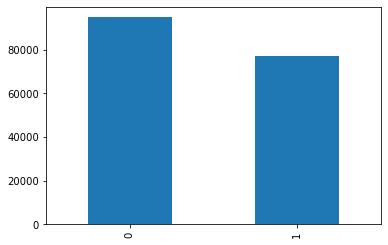

In [12]:
win.plot(kind='bar')

In [13]:
df = df.replace([' ','NULL','na','(none)'],np.nan)

In [14]:
# drop any NaNs
df_2 = df.dropna()

In [15]:
df_2.shape

(114648, 10)

In [16]:
df_2.dtypes

date                int64
day_of_week         int64
v_game_number       int64
h_game_number       int64
v_score             int64
h_score             int64
day_night         float64
attendance        float64
length_minutes    float64
vist_win            int32
dtype: object

## Modeling

In [17]:
#ML model
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer 
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_validate

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

In [18]:
#VS
from yellowbrick.classifier import classification_report, confusion_matrix, discrimination_threshold

In [27]:
features = df_2[[
    'date', 'day_of_week','v_game_number','h_game_number'
    ,'attendance','length_minutes', 'day_night']]

target = df_2[['vist_win']].values.ravel()

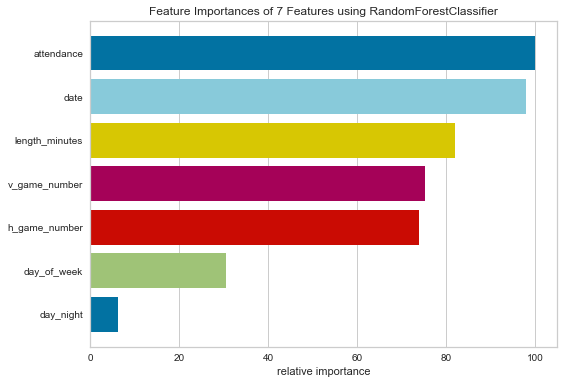

<AxesSubplot:title={'center':'Feature Importances of 7 Features using RandomForestClassifier'}, xlabel='relative importance'>

In [28]:
from sklearn.ensemble import RandomForestClassifier

from yellowbrick.datasets import load_occupancy
from yellowbrick.model_selection import FeatureImportances

# Load the classification data set

model = RandomForestClassifier(n_estimators=10)
viz = FeatureImportances(model)
viz.fit(features, target)
viz.show()

In [29]:
#split the data
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2
)

In [30]:
X_train.shape

(91718, 7)

In [31]:
y_train.shape

(91718,)

In [32]:
# Taking the best seven features and applying them to different ML models
cross_validate(GaussianNB(), X_train, y_train, cv=TimeSeriesSplit(), scoring='f1_macro')

{'fit_time': array([0.01373196, 0.02390671, 0.02690959, 0.03388643, 0.03986621]),
 'score_time': array([0.01999521, 0.01498032, 0.01594687, 0.01495028, 0.01495028]),
 'test_score': array([0.5006232 , 0.50244486, 0.50695825, 0.50076686, 0.48913387])}

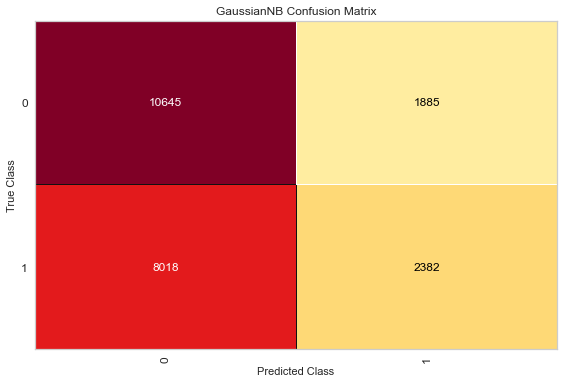

ConfusionMatrix(ax=<AxesSubplot:title={'center':'GaussianNB Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>,
                cmap=<matplotlib.colors.ListedColormap object at 0x0000015F1D001880>,
                estimator=GaussianNB(), is_fitted=False)

In [33]:
confusion_matrix(GaussianNB(), X_train, y_train, X_test, y_test, is_fitted=False)

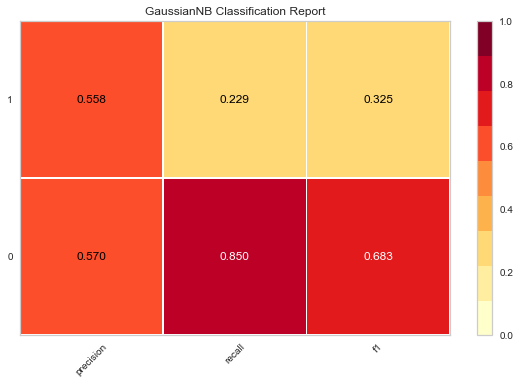

ClassificationReport(ax=<AxesSubplot:title={'center':'GaussianNB Classification Report'}>,
                     cmap=<matplotlib.colors.ListedColormap object at 0x0000015F1D281C40>,
                     estimator=GaussianNB(), is_fitted=False)

In [34]:
classification_report(GaussianNB(), X_train, y_train, X_test, y_test,scoring='f1_macro', is_fitted=False)

In [ ]:
cross_validate(SVC(kernel='rbf', degree=3), X_train, y_train, cv=TimeSeriesSplit(), scoring='f1_macro')

In [ ]:
confusion_matrix(SVC(kernel='rbf', degree=3), X_train, y_train, X_test, y_test, is_fitted=False)

In [ ]:
classification_report(SVC(kernel='rbf', degree=3), X_train, y_train, X_test, y_test,scoring='f1_macro', is_fitted=False)

In [35]:
cross_validate(KNeighborsClassifier(n_neighbors=5), X_train, y_train, cv=TimeSeriesSplit(),
               scoring='f1_macro')

{'fit_time': array([0.0749681 , 0.14251375, 0.23321891, 0.30606937, 0.41328168]),
 'score_time': array([0.84294415, 0.83938813, 0.86546111, 0.85373497, 0.84501815]),
 'test_score': array([0.51404498, 0.50201826, 0.49623808, 0.49858662, 0.496927  ])}

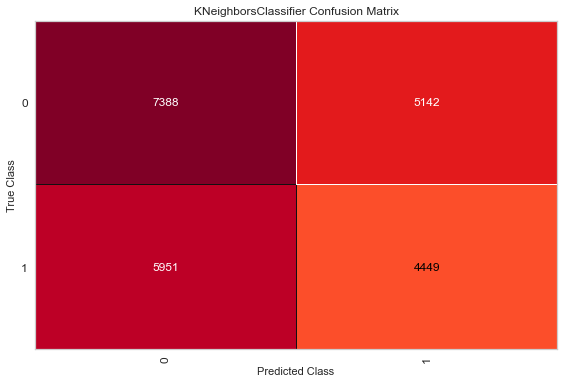

ConfusionMatrix(ax=<AxesSubplot:title={'center':'KNeighborsClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>,
                cmap=<matplotlib.colors.ListedColormap object at 0x0000015F1D698BE0>,
                estimator=KNeighborsClassifier(), is_fitted=False)

In [36]:
confusion_matrix(KNeighborsClassifier(n_neighbors=5), X_train, y_train, X_test, y_test, is_fitted=False)

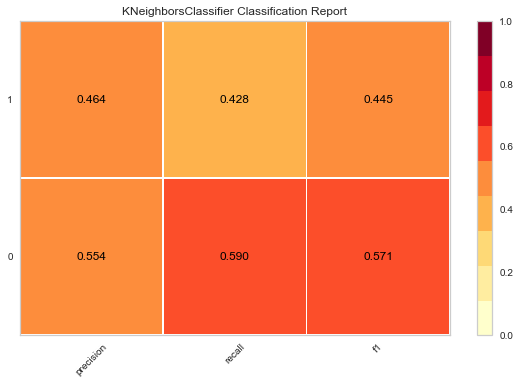

ClassificationReport(ax=<AxesSubplot:title={'center':'KNeighborsClassifier Classification Report'}>,
                     cmap=<matplotlib.colors.ListedColormap object at 0x0000015F1E81AC10>,
                     estimator=KNeighborsClassifier(), is_fitted=False)

In [37]:
classification_report(KNeighborsClassifier(n_neighbors=5), X_train, y_train, X_test, y_test,scoring='f1_macro', is_fitted=False)

In [38]:
cross_validate(LogisticRegression(), X_train, y_train, cv=TimeSeriesSplit(), scoring='f1_macro')

{'fit_time': array([0.05551958, 0.05575371, 0.0798924 , 0.10359979, 0.12863779]),
 'score_time': array([0.0141294 , 0.01515341, 0.01286364, 0.01295614, 0.01309395]),
 'test_score': array([0.35014029, 0.3493104 , 0.35434002, 0.35412177, 0.35000213])}

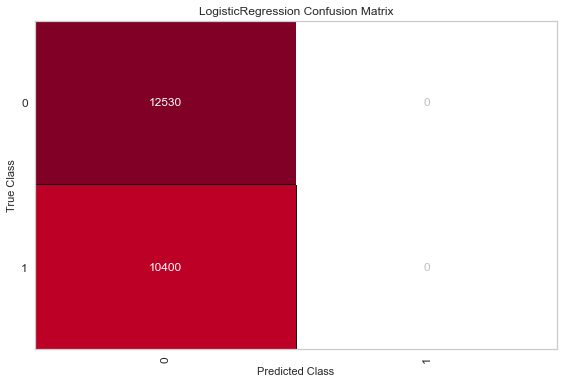

ConfusionMatrix(ax=<AxesSubplot:title={'center':'LogisticRegression Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>,
                cmap=<matplotlib.colors.ListedColormap object at 0x0000015F1D281100>,
                estimator=LogisticRegression(), is_fitted=False)

In [39]:
confusion_matrix(LogisticRegression(), X_train, y_train, X_test, y_test, is_fitted=False)

C:\Users\amjad\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


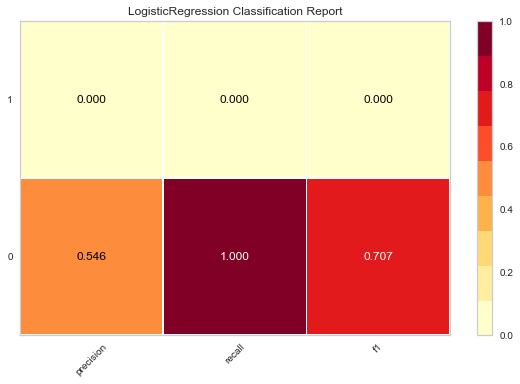

ClassificationReport(ax=<AxesSubplot:title={'center':'LogisticRegression Classification Report'}>,
                     cmap=<matplotlib.colors.ListedColormap object at 0x0000015F2003FE50>,
                     estimator=LogisticRegression(), is_fitted=False)

In [40]:
classification_report(LogisticRegression(), X_train, y_train, X_test, y_test,scoring='f1_macro', is_fitted=False)